In [1]:
from burstfit.fit import BurstFit
from burstfit.data import BurstData
from burstfit.model import Model, SgramModel
from burstfit.utils.plotter import plot_2d_fit
from burstfit.utils.functions import gauss_norm2, pulse_fn_vec, sgram_fn_vec
from burstfit.io import BurstIO

import numpy as np
import logging

In [2]:
logging_format = "%(asctime)s - %(funcName)s -%(name)s - %(levelname)s - %(message)s"
logging.basicConfig(
    level=logging.INFO,
    format=logging_format,
)

## Before we use MCMC for fitting, we need to use BurstFit to estimate initial set of parameters for MCMC

### Read data, preprocess, fit..

In [3]:
import tempfile
from urllib.request import urlretrieve

temp_dir = tempfile.TemporaryDirectory()
download_path = str(temp_dir.name) + "/FRB180417.fil"
url = "https://zenodo.org/record/3905426/files/FRB180417.fil"
urlretrieve(
    url, download_path,
)
fil_file = download_path

bd = BurstData(
    fp=fil_file,
    dm=475.28400,
    tcand=2.0288800,
    width=2,
    snr=16.8128,
    min_samp=256,
)
bd.prepare_data()

2021-03-16 18:02:32,387 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2021-03-16 18:02:32,394 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2021-03-16 18:02:32,395 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2021-03-16 18:02:32,398 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (127.98158986433457, 18.365628141947383)


Using <class 'str'>:
/tmp/tmpjqt0hory/FRB180417.fil

In [4]:
max_ncomp = 3
plot = False
profile_bounds = []
spectra_bounds = ([0, 0, 200, 0, 0], [100, 50, 300, 50, 1])
pnames = ['S', 'mu_t', 'sigma_t', 'tau']
snames = ['mu_f1', 'sigma_f1', 'mu_f2', 'sigma_f2', 'amp']

bd.prepare_data()

pulseModel = Model(pulse_fn_vec, param_names=pnames)
spectraModel = Model(gauss_norm2, param_names=snames)
sgramModel = SgramModel(pulseModel, spectraModel, sgram_fn_vec, 
                        mask=bd.mask, clip_fac=bd.clip_fac)

bf = BurstFit(
    sgram_model=sgramModel,
    sgram=bd.sgram,
    width=bd.width,
    dm=bd.dm,
    foff=bd.foff,
    fch1=bd.fch1,
    tsamp=bd.tsamp,
    clip_fac=bd.clip_fac,
    mask=bd.mask, 
    mcmcfit=False
)
bf.fitall(plot=False, max_ncomp=max_ncomp, 
          profile_bounds=profile_bounds,
          spectra_bounds=spectra_bounds)

2021-03-16 18:02:32,411 - prepare_data -burstfit.data - INFO - Preparing data for burst fitting.
2021-03-16 18:02:32,416 - crop_dedispersed_data -burstfit.data - INFO - Cropping data with time_window: 0.2s.
2021-03-16 18:02:32,417 - normalise_data -burstfit.data - INFO - Normalising data using off pulse mean and std.
2021-03-16 18:02:32,420 - normalise_data -burstfit.data - INFO - Off pulse mean and std are: (127.98158986433457, 18.365628141947383)
2021-03-16 18:02:32,422 - run_tests -burstfit.fit - INFO - Running statistical tests on the residual.
2021-03-16 18:02:32,422 - run_tests -burstfit.fit - INFO - Running off pulse - off pulse test
2021-03-16 18:02:32,427 - tests -root - INFO - P values: T-test (0.65766), Kruskal (0.71932), KS (0.59128), F-test (0.29584)
2021-03-16 18:02:32,427 - run_tests -burstfit.fit - INFO - Running on pulse - off pulse (L) test
2021-03-16 18:02:32,431 - tests -root - INFO - P values: T-test (0.00000), Kruskal (0.00000), KS (0.00000), F-test (0.00053)
2021

### Now we will use the fitted parameters from fitall() as initial guess to MCMC. 
#### We will set different inputs/config for MCMC in a dictionary
#### Ideally, nsteps should be really huge, as we use autocorrelation analysis to check if our chains have converged. See: https://emcee.readthedocs.io/en/stable/tutorials/autocorr/. But this is a tutorial, so we will use a small number. 

#### The priors are set based on the initial guess and some rules (eg: minimum prior for tau is 0, etc). 
#### Walkers are assigned random initial positions near the initial guess. 
#### save_results can be used to save the h5 file with samples, and MCMC result plots.

2021-03-16 18:02:32,931 - set_initial_pos -root - INFO - Setting initial positions for MCMC.
2021-03-16 18:02:32,932 - set_initial_pos -burstfit.mcmc - INFO - Initial guess for MCMC is: [7.46600996e+01 2.90899745e+01 2.82098756e+02 4.80475705e+01
 4.12347636e-01 5.55896026e+02 7.90266031e+01 7.84458296e-01
 7.02617870e-02 4.74575500e+02]
2021-03-16 18:02:32,933 - set_priors -burstfit.mcmc - INFO - Setting priors for MCMC.
2021-03-16 18:02:32,934 - set_priors -burstfit.mcmc - INFO - Found tau in param_names. Setting its min value of prior to 0.
2021-03-16 18:02:32,935 - set_priors -burstfit.mcmc - INFO - Found sigma_t in param_names. Setting its min value of prior to 0.
2021-03-16 18:02:32,935 - set_priors -burstfit.mcmc - INFO - Found sigma_t and tau in param_names. Setting its max value of prior to 2*(max_tau_prior(0.12647121664840297) + max_sigma_t_prior(1.4120249336903075))
2021-03-16 18:02:32,936 - set_priors -burstfit.mcmc - INFO - Found S and sigma_t in param_names. Setting its m

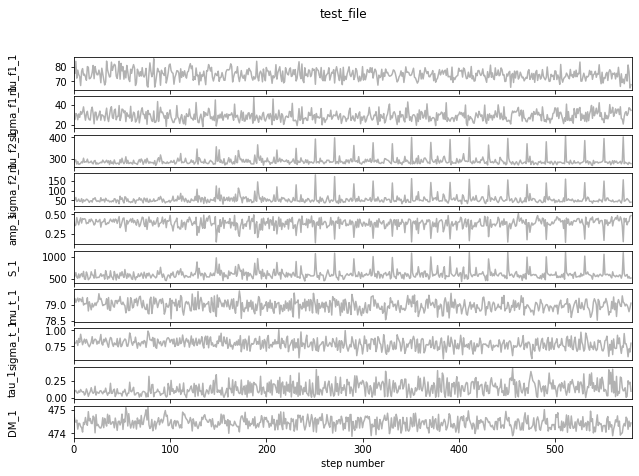

<Figure size 432x288 with 0 Axes>

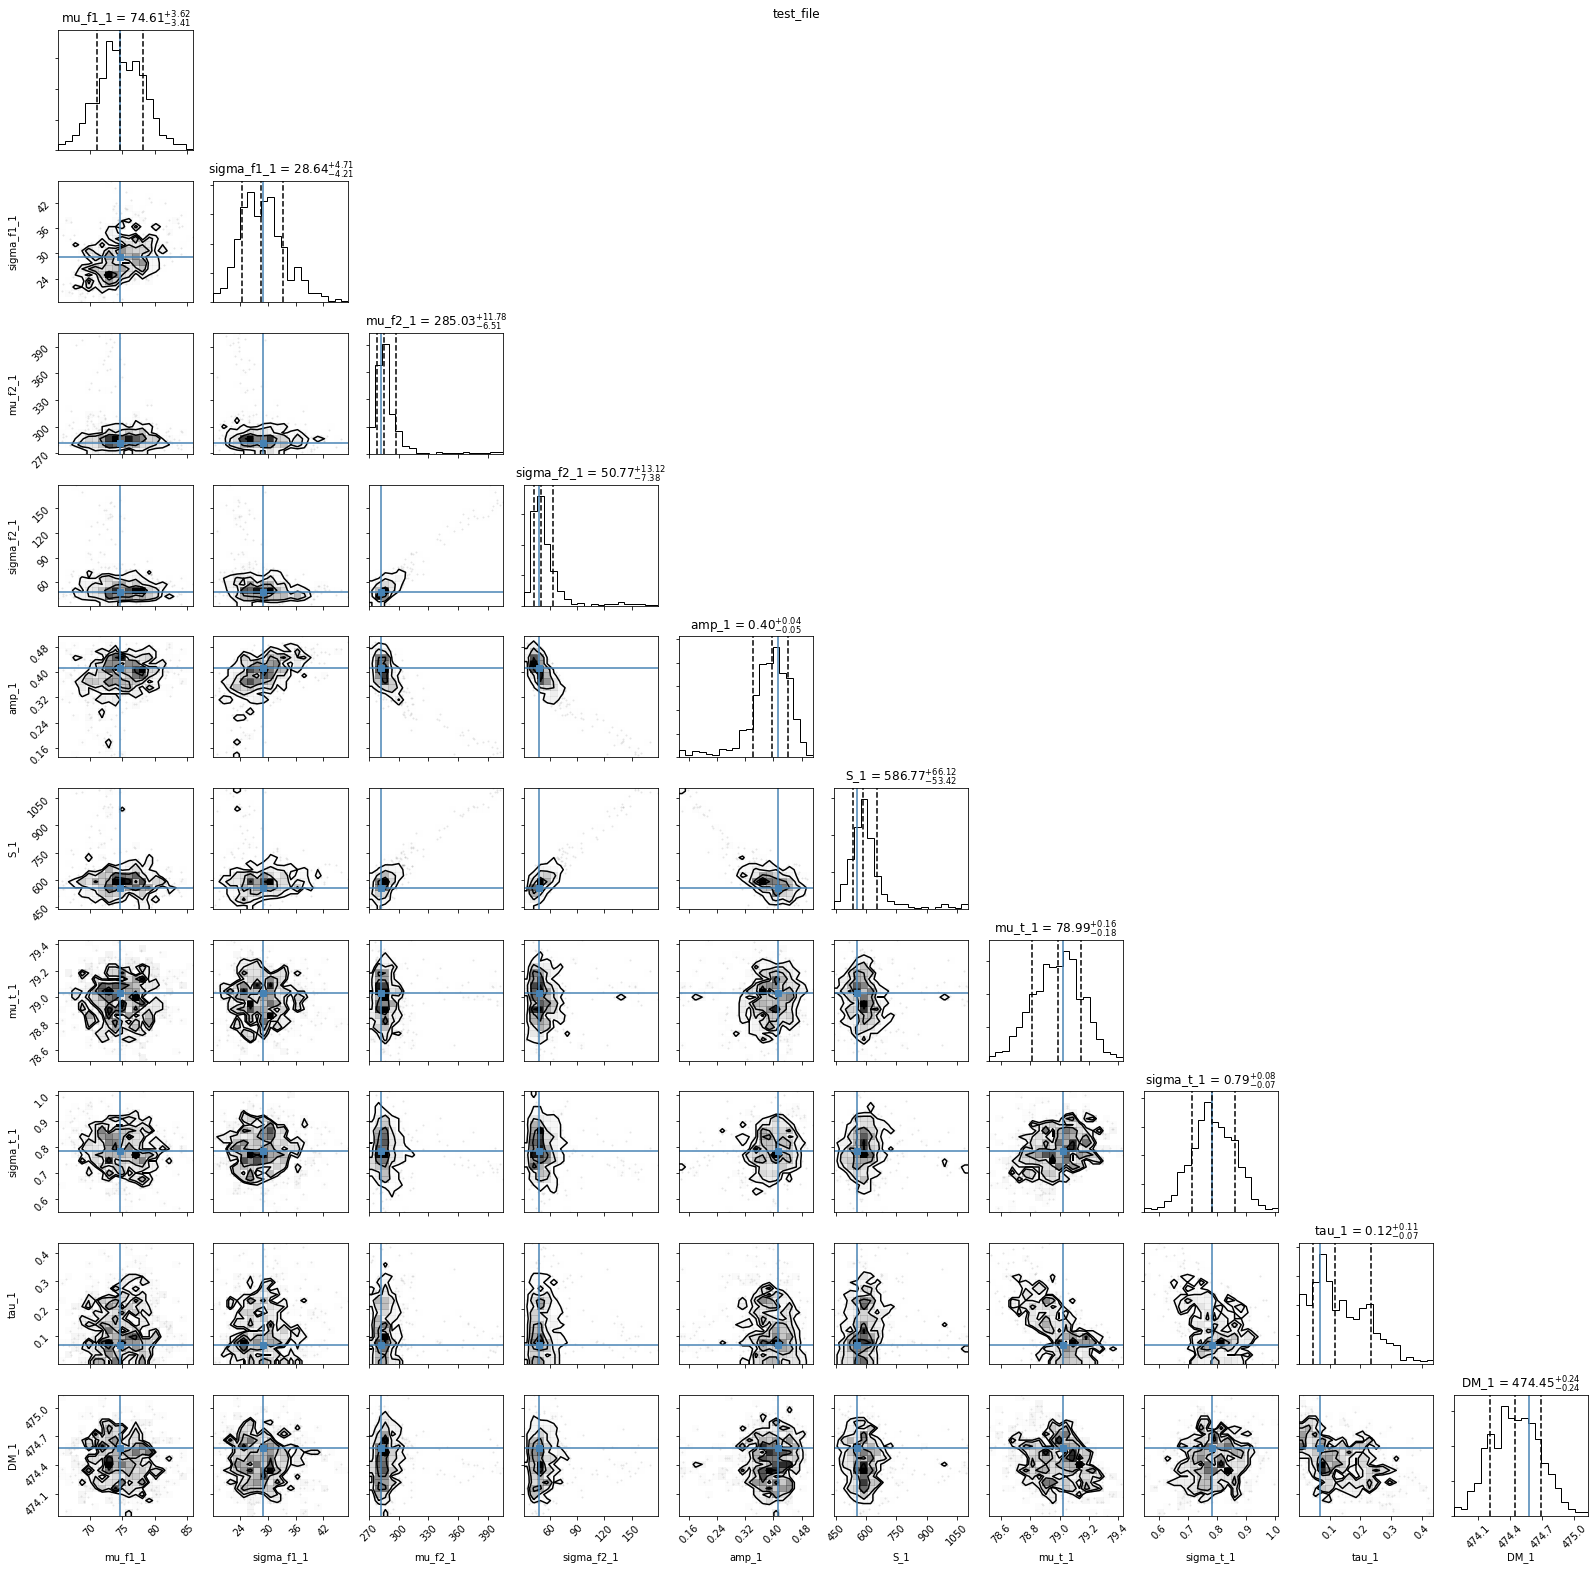

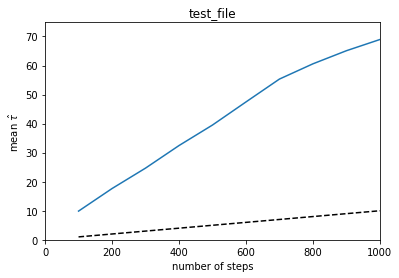

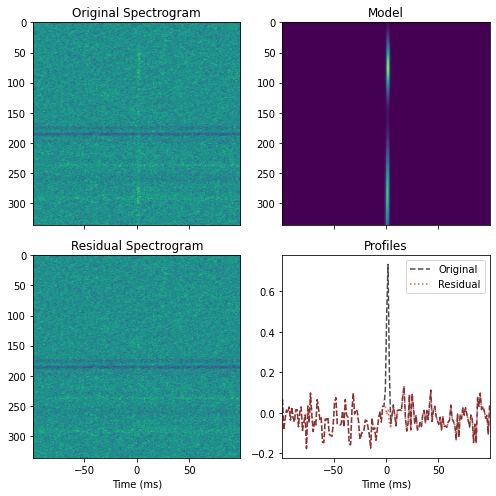

In [5]:
mcmc_kwargs = {}
mcmc_kwargs = {'nwalkers':20, 'nsteps':1000,
               'skip':500, 'ncores':4, 
               'start_pos_dev':0.01,
               'prior_range':0.8, 
               'save_results':True,
               'outname':'test_file'}
bf.run_mcmc(plot=True, **mcmc_kwargs)

#### The four plots above are the following: 
#### 1. Chains for all the parameters
#### 2. Corner plot using the MCMC samples
#### 3. Autocorrelation plot. Blue line is autocorrelation timescale, and dotted line is N/50
#### 4. Fitting results. 

In [6]:
# the parameters are saved in mcmc_params
bf.mcmc_params

{1: {'popt': [74.60538993085184,
   28.64438475491754,
   285.0279513720777,
   50.77000996480871,
   0.3957172446411926,
   586.7738944008156,
   78.98710549422722,
   0.7850597330539902,
   0.11901921778073798,
   474.4486279880457],
  'perr': [[3.4052083742582084, 3.623236564921555],
   [4.2128525217698325, 4.7071420647637865],
   [6.513463454752241, 11.781445771213896],
   [7.3766270756232615, 13.124523004708848],
   [0.05354824030143529, 0.04408905639677324],
   [53.422922284540164, 66.11767739423124],
   [0.176528792337578, 0.16149591207445724],
   [0.072184171103307, 0.07941089713133642],
   [0.0727322324667249, 0.11420295213805237],
   [0.23815270791340026, 0.2364798579969829]]}}